In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import stft
import os
import pandas as pd
import sys
import glob
import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.preprocessing import MinMaxScaler
import nbimporter
from transformer_model import WordPiece, Evaluator, BlandAltman2, Objective, BestModelLoader, normalize_data1, normalize_data2, denormalize_data,scatter,find_ids
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score
from torch.nn.utils.rnn import pad_sequence
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders
import optuna
import json
from dataprocess import OutputDataProcessor, DataProcessor, pad_truncate_sequences,DatasetManager
import pickle

In [2]:
import logging
import random
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """

    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")

set_seed(0)

In [3]:
data = np.load(r'F:\junwei\CNN\CNN_keras\data.npy')
output_data = pd.read_excel('F:\junwei\dataset\_MASTER_modified.xlsx',usecols=['Crs', 'R'])
train = pd.read_csv(r'F:\junwei\CNN\CNN_keras\train.csv')
test = pd.read_csv(r'F:\junwei\CNN\CNN_keras\test.csv')
val = pd.read_csv(r'F:\junwei\CNN\CNN_keras\val.csv')
volume = data[:,:,0]
flow = data[:,:,1]
pressure= data[:,:,2]
Crs = output_data['Crs']
R = output_data['R']
Crs = Crs.T
R= R.T
flow = flow.T
pressure = pressure.T
volume = volume.T
num_examples = flow.shape[0]
num_samples = flow.shape[1]

output_data = np.stack((Crs,R),axis=1)
output_data = pd.DataFrame(output_data)
output_data = output_data.rename(columns={0: "Crs", 1: "R"})
signals = np.stack([flow, volume, pressure], axis=2)
signals = np.transpose(signals, (1, 0, 2))
indices_train = train['Unnamed: 0'].values
indices_test = test['Unnamed: 0'].values
indices_val = val['Unnamed: 0'].values
train_input = signals[indices_train,:,:]
test_input = signals[indices_test,:,:]
val_input = signals[indices_val,:,:]
train_output = output_data.loc[indices_train]
test_output = output_data.loc[indices_test]
val_output = output_data.loc[indices_val]

In [4]:
import numpy as np
from scipy.signal import argrelextrema

def extract_signal_features(input_array):
    features = []
    median_maxima = []
    median_minima = []

    for sample in input_array:
        sample_features = []
        sample_maxima = []
        sample_minima = []
        
        for signal in sample.T:  # Transpose to iterate over signals instead of time steps
            maxima_indices = argrelextrema(signal, np.greater)[0]
            minima_indices = argrelextrema(signal, np.less)[0]

            min_length = min(len(maxima_indices), len(minima_indices))
            maxima_indices = maxima_indices[:min_length]
            minima_indices = minima_indices[:min_length]

            differences = signal[maxima_indices] - signal[minima_indices]
            feature = np.median(differences)
            sample_features.append(feature)

            median_max = np.median(signal[maxima_indices])
            median_min = np.median(signal[minima_indices])
            sample_maxima.append(median_max)
            sample_minima.append(median_min)
        
        features.append(sample_features)
        median_maxima.append(sample_maxima)
        median_minima.append(sample_minima)

    features = np.array(features)
    median_maxima = np.array(median_maxima)
    median_minima = np.array(median_minima)

    return np.concatenate((features, median_maxima, median_minima), axis=1)

# usage
train_features = extract_signal_features(train_input)
test_features = extract_signal_features(test_input)



In [5]:
train_features.shape

(309, 9)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

clf = LinearRegression()
clf = clf.fit(train_features, train_output)
predicted = clf.predict(test_features)
test_output = test_output.to_numpy()


In [7]:
print(type(predicted))
print(type(test_output))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
print(f"MAPE for C: {metrics.mean_absolute_percentage_error(test_output[:, 0], predicted[:, 0])*100}")
print(f"MAE for C: {metrics.mean_absolute_error(test_output[:, 0], predicted[:, 0])}")
print(f"MSE for C: {metrics.mean_squared_error(test_output[:, 0], predicted[:, 0])}")
print()
print(f"MAPE for R: {metrics.mean_absolute_percentage_error(test_output[:, 1], predicted[:, 1])*100}")
print(f"MAE for R: {metrics.mean_absolute_error(test_output[:, 1], predicted[:, 1])}")
print(f"MSE for R: {metrics.mean_squared_error(test_output[:, 1], predicted[:, 1])}")

MAPE for C: 16.663184128928286
MAE for C: 7.359818845089431
MSE for C: 91.82911048847423

MAPE for R: 22.13913068565065
MAE for R: 3.3356176554098096
MSE for R: 30.818531332465337


In [9]:
import numpy as np
import matplotlib.pyplot as plt

class BlandAltman2:
    def __init__(self, output_data_unscaled, pre_data_unscaled):
        self.output_data_unscaled = output_data_unscaled
        self.pre_data_unscaled = pre_data_unscaled

    def plot(self, x_label, start, xlim_range,start_y,ylim_range):
        # Convert the values to numpy arrays
        output_data = np.asarray(self.output_data_unscaled)
        pre_data = np.asarray(self.pre_data_unscaled)

        # Calculate the difference and mean
        diff = output_data - pre_data
        mean = (output_data + pre_data) / 2

        # Calculate the percentage difference between predictions and targets
        percentage_diff = (diff / mean) * 100

        # Calculate the mean and standard deviation of the percentage difference
        mean_diff = np.mean(percentage_diff)
        std_diff = np.std(percentage_diff)

        overestimate_indices = []
        underestimate_indices = []
        # Find indices of outliers
        outlier_indices = []

        for i, percentage_error in enumerate(percentage_diff):
            if percentage_error > 20:  # overestimate
                outlier_indices.append(i)
                overestimate_indices.append(i)
            elif percentage_error < -20:  # underestimate
                outlier_indices.append(i)
                underestimate_indices.append(i)

        # Plot the Bland-Altman plot with percentage difference
        fig, ax = plt.subplots(figsize=(8, 5.5))
        for i in range(len(percentage_diff)):
            if i in outlier_indices:
                ax.scatter(output_data[i], percentage_diff[i], color='red', s=15)
            else:
                ax.scatter(output_data[i], percentage_diff[i], color='blue', s=15)
        ax.axhline(mean_diff, color='gray', linestyle='--',lw = 2)
        upper_limit = mean_diff + 1.96 * std_diff
        lower_limit = mean_diff - 1.96 * std_diff
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(20, color='green', linestyle='-',lw = 2.5)
        ax.axhline(-20, color='green', linestyle='-',lw = 2.5)
        ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel('Percentage Difference between Predictions and Targets', fontsize=11)
        #ax.set_title('Bland-Altman Plot', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(start, xlim_range)
        ax.set_ylim(start_y, ylim_range)
        #yticks = np.arange(start_y, ylim_range + 1, 10)  
        #plt.yticks(yticks)
        ax.set_yticks([-60,-50,-40,-30,-20,-10, 0, 10,20,30,40,50,60])
        plt.show()
        print("The Y-coordinate for the upper gray line is: ", upper_limit)
        print("The Y-coordinate for the lower gray line is: ", lower_limit)
        print(f"Mean difference line Y-value: {mean_diff}")
        # Print indices of outliers
        #print("Indices of outliers: ", outlier_indices)
        #print("Indices of overestimations: ", overestimate_indices)
        #print("Indices of underestimations: ", underestimate_indices)
        return outlier_indices, overestimate_indices, underestimate_indices


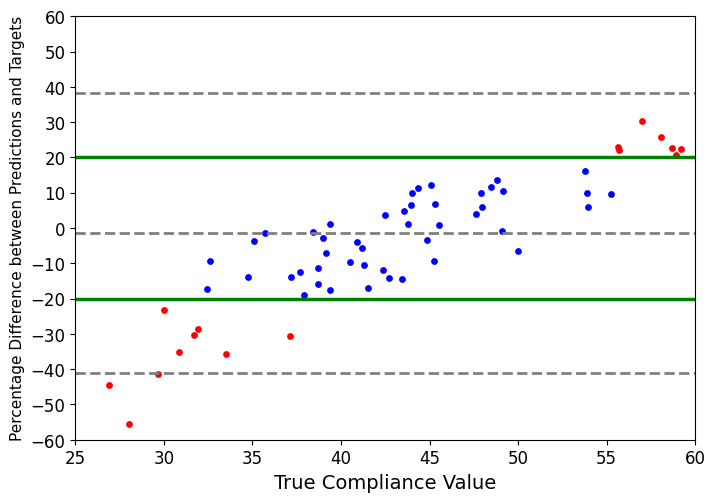

The Y-coordinate for the upper gray line is:  38.3467398838463
The Y-coordinate for the lower gray line is:  -40.979159749683845
Mean difference line Y-value: -1.3162099329187742


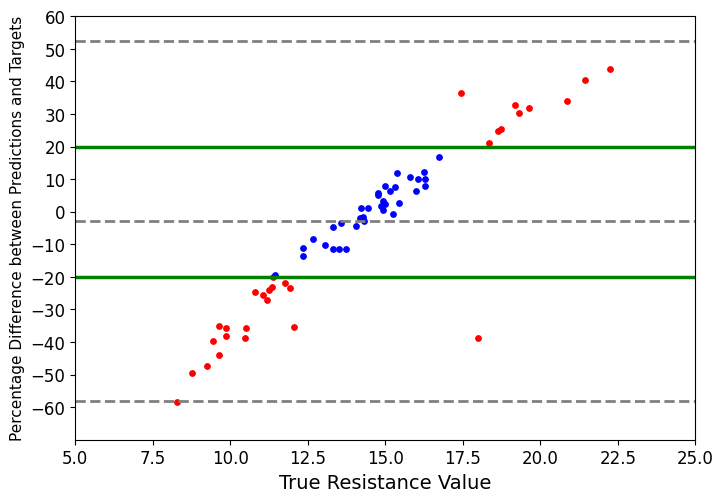

The Y-coordinate for the upper gray line is:  52.28875528394429
The Y-coordinate for the lower gray line is:  -57.9855834375665
Mean difference line Y-value: -2.8484140768111015


In [10]:
bland_C = BlandAltman2(test_output[:, 0], predicted[:, 0])
bland_R = BlandAltman2(test_output[:, 1], predicted[:, 1])

outlier_indices_C = bland_C.plot('True Compliance Value',25,60,-60,40)
outlier_indices_R = bland_R.plot('True Resistance Value',5,25,-70,50) 

In [9]:
#index1 = 296
#plt.figure()
#plt.plot(flow[index1])
#plt.xlabel('Time')
#plt.ylabel('Flow')
#plt.title('Flow - Sample {}'.format(index1))
#plt.show()

# Plot for pressure
#plt.figure()
#plt.plot(pressure[index1])
#plt.xlabel('Time')
#plt.ylabel('Pressure')
#plt.title('Pressure - Sample {}'.format(index1))
#plt.show()

# Plot for volume
##plt.figure()
#plt.plot(volume[index1])
#plt.xlabel('Time')
#plt.ylabel('Volume')
#plt.title('Volume - Sample {}'.format(index1))
#plt.show()

In [10]:
#plt.scatter(C_true, C_pre)

# Add labels and title
##plt.xlabel('C_true')
#plt.ylabel('C_pre')
#plt.title('C_true vs C_pre')

# Display the plot
#plt.show()

In [11]:
#sequence_tokenizer = WordPiece(vocab_size=2000,max_seq_len=60)
#sequence_tokenizer.train_tokenizer(data)
#directory = r'F:\junwei\final_tranformer\transformer_C _R\wordpiece'

#file_path = os.path.join(directory, 'sequence_tokenizer.pkl')

#with open(file_path, 'wb') as f:
#   pickle.dump(sequence_tokenizer, f)

In [12]:
#train_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\train_data.pickle')
#test_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\test_data.pickle')
#val_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\val_data.pickle')

In [13]:
import numpy as np

def count_lengths(data):
    lengths_dict = {
        '70-80': 0,
        '80-90': 0,
        '90-100': 0,
        '100-110': 0,
        '110-120': 0,
        '120-130': 0,
        '130-140': 0,
        '140-150': 0,
        '150-160': 0,
        '160-170': 0,
        '170-180': 0,
        '180-190': 0,
        '190-200': 0,
        '200-210': 0,
        '210-220': 0,
        '220-230': 0,
        '230-240': 0,
        '250-260': 0
    }

    for sentence in data:
        # Remove padding
        sentence = sentence[sentence != 0]
        
        # Count length
        length = len(sentence)

        # Classify length
        if 70 <= length < 80:
            lengths_dict['70-80'] += 1
        elif 80 <= length < 90:
            lengths_dict['80-90'] += 1
        elif 90 <= length < 100:
            lengths_dict['90-100'] += 1
        elif 100 <= length < 110:
            lengths_dict['100-110'] += 1
        elif 110 <= length < 120:
            lengths_dict['110-120'] += 1
        elif 120 <= length < 130:
            lengths_dict['120-130'] += 1
        elif 130 <= length < 140:
            lengths_dict['130-140'] += 1
        elif 140 <= length < 150:
            lengths_dict['140-150'] += 1
        elif 150 <= length < 160:
            lengths_dict['150-160'] += 1
        elif 160 <= length < 170:
            lengths_dict['160-170'] += 1
        elif 170 <= length < 180:
            lengths_dict['170-180'] += 1
        elif 180 <= length < 190:
            lengths_dict['180-190'] += 1
        elif 190 <= length < 200:
            lengths_dict['190-200'] += 1
        elif 200 <= length < 210:
            lengths_dict['200-210'] += 1
        elif 210 <= length < 220:
            lengths_dict['210-220'] += 1
        elif 220 <= length < 230:
            lengths_dict['220-230'] += 1
        elif 230 <= length < 240:
            lengths_dict['230-240'] += 1
        elif 240 <= length < 250:
            lengths_dict['240-250'] += 1

    return lengths_dict

# Call the function
lengths_dict = count_lengths(padded_data)

# Print the result
for k, v in lengths_dict.items():
    print(f"Number of samples with length {k}: {v}")


NameError: name 'padded_data' is not defined